In [1]:
import numpy as np
from qiskit_optimization import QuadraticProgram
from qiskit import Aer,QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from itertools import product

<h3> Setting Up Quantum Annealer

In [2]:
from decimal import Decimal
import dimod
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.system import LeapHybridSampler

In [3]:
def annealer_solver(qubo_matrix,backend="Classical",shots =1000):
    qubo_dict = {}

    for i in range(qubo_matrix.shape[0]):
        for j in range(qubo_matrix.shape[1]):
            if i == j:
                qubo_dict[(i,j)] = qubo_matrix[i,j]
            elif i != j:
                qubo_dict[(i,j)] = qubo_matrix[i,j]
            else:
                pass


    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo_dict)

    if backend == "Classical":
        print("\nPlease wait, while the Classical engine is running....")
        sampleset = dimod.SimulatedAnnealingSampler().sample(bqm, num_reads=shots)

    elif backend == "Quantum":
        print("\nPlease wait, while the Quantum engine is running....")
        sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=shots)

    elif backend == "Hybrid":
        print("\nPlease wait, while the Hybrid Classical-Quantum engine is running....")
        sampleset = LeapHybridSampler().sample(bqm)
    
    else:
        print("\n\nPlease select a valid backend!")
        pass

    best_sample = list(sampleset.first.sample.values())
    return (best_sample)

<h3> Stock List

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [5]:
stocks=['TSLA','AMZN','AAPL','NFLX','GOOG']
start_date = '2020-01-01'
end_date = '2022-01-01'

In [6]:
df=pd.DataFrame()

for stock in stocks:
    df[stock] = yf.Ticker(stock).history(start = start_date, end = end_date, interval = '1d')['Close']

In [7]:
df

,TSLA,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-02 00:00:00-05:00,28.684000,94.900497,73.561531,329.809998,68.368500
2020-01-03 00:00:00-05:00,29.534000,93.748497,72.846375,325.899994,68.032997
2020-01-06 00:00:00-05:00,30.102667,95.143997,73.426819,335.829987,69.710503
2020-01-07 00:00:00-05:00,31.270666,95.343002,73.081490,330.750000,69.667000
2020-01-08 00:00:00-05:00,32.809334,94.598503,74.257095,339.260010,70.216003
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,364.646667,169.669495,179.289444,613.119995,148.063995
2021-12-28 00:00:00-05:00,362.823334,170.660995,178.255447,610.710022,146.447998
2021-12-29 00:00:00-05:00,362.063324,169.201004,178.344925,610.539978,146.504501


<AxesSubplot:xlabel='Date'>

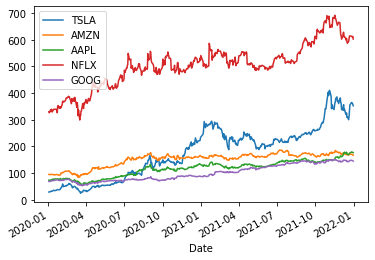

In [8]:
df.plot()

In [9]:
daily_returns = df.pct_change().dropna()
daily_returns

,TSLA,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-03 00:00:00-05:00,0.029633,-0.012139,-0.009722,-0.011855,-0.004907
2020-01-06 00:00:00-05:00,0.019255,0.014886,0.007968,0.030469,0.024657
2020-01-07 00:00:00-05:00,0.038801,0.002092,-0.004703,-0.015127,-0.000624
2020-01-08 00:00:00-05:00,0.049205,-0.007809,0.016086,0.025729,0.007880
2020-01-09 00:00:00-05:00,-0.021945,0.004799,0.021241,-0.010611,0.011044
...,...,...,...,...,...
2021-12-27 00:00:00-05:00,0.025248,-0.008178,0.022975,-0.001580,0.006263
2021-12-28 00:00:00-05:00,-0.005000,0.005844,-0.005767,-0.003931,-0.010914
2021-12-29 00:00:00-05:00,-0.002095,-0.008555,0.000502,-0.000278,0.000386


<h3> Q1 Constrained QUBO

In [10]:
mu = daily_returns.mean() * 252
mu

TSLA    1.532392
AMZN    0.333350
AAPL    0.508189
NFLX    0.379790
GOOG    0.425778
dtype: float64

In [11]:
cov = daily_returns.cov() * 252
cov

,TSLA,AMZN,AAPL,NFLX,GOOG
TSLA,0.552818,0.101450,0.129907,0.109659,0.095602
AMZN,0.101450,0.103287,0.080707,0.078037,0.066768
AAPL,0.129907,0.080707,0.140395,0.076669,0.083340
NFLX,0.109659,0.078037,0.076669,0.158227,0.063968
GOOG,0.095602,0.066768,0.083340,0.063968,0.101440


According to MPT, 

$$\min_{\vec{x}}\,\, -x^{T}\mu + \frac{\gamma}{2} x^T \Sigma x$$

In [12]:
mu

TSLA    1.532392
AMZN    0.333350
AAPL    0.508189
NFLX    0.379790
GOOG    0.425778
dtype: float64

In [13]:
np.diag(mu)

array([[1.53239232, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33335037, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.50818944, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.3797901 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.42577824]])

Considering the $L^1$ norm of $x$ vector to be 3 that is,

$$\sum_{i=0}^4 |x_i|=3$$

The associated constraint should be,

$$C=\min_x\left(\sum_{i=0}^4 x_i-3\right)^2=\min_x x^T(J_5-2\cdot 3I_5)x$$

where $J_5$ is a $5\times 5$ matrix with all element 1. I'm not considering the absolute value of $x_i$ because $x_i\in\{0,1\}$.

In [14]:
Jn=np.ones((5,5))
In=np.identity(5)
C=Jn-2*3*In
C

array([[-5.,  1.,  1.,  1.,  1.],
       [ 1., -5.,  1.,  1.,  1.],
       [ 1.,  1., -5.,  1.,  1.],
       [ 1.,  1.,  1., -5.,  1.],
       [ 1.,  1.,  1.,  1., -5.]])

In [15]:
gamma = 1  #risk aversion parameter
qubo = -1*np.diag(mu) + (gamma/2)*np.array(cov) + C
qubo

array([[-6.25598324,  1.05072518,  1.06495328,  1.05482952,  1.04780118],
       [ 1.05072518, -5.28170699,  1.04035328,  1.03901862,  1.03338399],
       [ 1.06495328,  1.04035328, -5.437992  ,  1.03833462,  1.04166983],
       [ 1.05482952,  1.03901862,  1.03833462, -5.30067645,  1.03198419],
       [ 1.04780118,  1.03338399,  1.04166983,  1.03198419, -5.37505837]])

<h3> Q1 Brute force solution

In [16]:
n = qubo.shape[0]
n

5

In [17]:
states = list(product([0,1],repeat = n))

In [18]:
print(f'\t State \t\t\t Cost')
best_cost = 0
for state in states:
    state = np.array(state).reshape(1,n)
    cost = float(state@qubo@state.T)
    print(f' {state} \t {cost}')
    
    if cost < best_cost:
        best_cost = cost
        best_state = state

print(f'Best state: {best_state} \t, cost: {best_cost}')

	 State 			 Cost
 [[0 0 0 0 0]] 	 0.0
 [[0 0 0 0 1]] 	 -5.375058367325562
 [[0 0 0 1 0]] 	 -5.3006764548764504
 [[0 0 0 1 1]] 	 -8.611766448970048
 [[0 0 1 0 0]] 	 -5.437991997799747
 [[0 0 1 0 1]] 	 -8.729710699732262
 [[0 0 1 1 0]] 	 -8.661999205416324
 [[0 0 1 1 1]] 	 -9.889749534116874
 [[0 1 0 0 0]] 	 -5.281706992075487
 [[0 1 0 0 1]] 	 -8.589997370367604
 [[0 1 0 1 0]] 	 -8.504346212688514
 [[0 1 0 1 1]] 	 -9.748668217748666
 [[0 1 1 0 0]] 	 -8.638992424398975
 [[0 1 1 0 1]] 	 -9.863943137298044
 [[0 1 1 1 0]] 	 -9.784962397752128
 [[0 1 1 1 1]] 	 -8.94594473741923
 [[1 0 0 0 0]] 	 -6.255983239505218
 [[1 0 0 0 1]] 	 -9.535439251835923
 [[1 0 0 1 0]] 	 -9.447000664011497
 [[1 0 0 1 1]] 	 -10.662488303110237
 [[1 0 1 0 0]] 	 -9.564068672199573
 [[1 0 1 0 1]] 	 -10.760185019137232
 [[1 0 1 1 0]] 	 -10.678416849445977
 [[1 0 1 1 1]] 	 -9.810564823151669
 [[1 1 0 0 0]] 	 -9.436239862067595
 [[1 1 0 0 1]] 	 -10.648927885364856
 [[1 1 0 1 0]] 	 -10.549220052310451
 [[1 1 0 1 1]] 	 -9.6

<h3> Q1 Annealer Solution

In [19]:
solution_dwave_q = annealer_solver(qubo, backend='Quantum')


Please wait, while the Quantum engine is running....


In [20]:
solution_dwave_q 

[1, 0, 1, 0, 1]

<h3> Q2 MPT Weight Calculation

In [21]:
from pypfopt import EfficientFrontier
ef = EfficientFrontier(mu, cov)
#ef.max_sharpe(risk_free_rate=0.02)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

OrderedDict([('TSLA', 0.5674), ('AMZN', 0.0), ('AAPL', 0.10522), ('NFLX', 0.0), ('GOOG', 0.32737)])


<h3> Q3(i) Fractional Binary Encoding

To do this encoding consider a basis transformation such that the weight vector transforms to,

$$\mathbf{w}^T_{1\times 5}=\mathbf{x}^T_{1\times 15}\mathbf{M}_{15\times 5}$$

where $x_i\in\{0,1\}$. For the quadratic term we shall have the transformation,

$$w^T\Sigma w\to x^TM\Sigma M^Tx$$

For linear term we shall have transformation,

$$w^T\mu\to x^TM\mu$$

This shall apply both to the original cost function terms and the constraint terms discussed above. The form of $M$ can be understood using the fact that,

$$w_i=\sum_{j=0}^{n-1}x_{ij}\alpha_j$$

where $n$ is the number of bit used and $\alpha_j$ are the encoding weights and taking $i$ running from 0 to $m-1$. We can consider shifting the index $i$ from $x$ to $\alpha$ and increase the number of elements. But to do that we need to take into consideration all the $m$ weights giving us $n\times m$ bit vector with $j$ running from 0 to $n\times m-1$ now. In that case $\alpha_{ij}\neq 0\,\forall\, 0\leq (j-ni)\leq n-1$.

In [22]:
enc_frac = np.array([(0.5)**3,(0.5)**2,(0.5)**1])
trans_mat1 = np.tensordot(np.identity(5), enc_frac, axes=0)
trans_mat1 = np.transpose(trans_mat1,(1, 2, 0)).reshape(15,5)
In1 = np.diag(trans_mat1@[1,1,1,1,1])
trans_mat1

array([[0.125, 0.   , 0.   , 0.   , 0.   ],
       [0.25 , 0.   , 0.   , 0.   , 0.   ],
       [0.5  , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.   , 0.   , 0.   ],
       [0.   , 0.25 , 0.   , 0.   , 0.   ],
       [0.   , 0.5  , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.125, 0.   , 0.   ],
       [0.   , 0.   , 0.25 , 0.   , 0.   ],
       [0.   , 0.   , 0.5  , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.125, 0.   ],
       [0.   , 0.   , 0.   , 0.25 , 0.   ],
       [0.   , 0.   , 0.   , 0.5  , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.125],
       [0.   , 0.   , 0.   , 0.   , 0.25 ],
       [0.   , 0.   , 0.   , 0.   , 0.5  ]])

In [23]:
C1=trans_mat1@Jn@trans_mat1.T-2*0.875*In1 
# 0.875 is considered instead of 1 because there seem to be an offset of 0.125 when the weights are added.
# While I am not sure what is causing this offset, provided that the code is correct,
# it might have something to do with the lowest non-zero value of the sum of all unconstrained weights being 0.125.
C1

array([[-0.203125,  0.03125 ,  0.0625  ,  0.015625,  0.03125 ,  0.0625  ,
         0.015625,  0.03125 ,  0.0625  ,  0.015625,  0.03125 ,  0.0625  ,
         0.015625,  0.03125 ,  0.0625  ],
       [ 0.03125 , -0.375   ,  0.125   ,  0.03125 ,  0.0625  ,  0.125   ,
         0.03125 ,  0.0625  ,  0.125   ,  0.03125 ,  0.0625  ,  0.125   ,
         0.03125 ,  0.0625  ,  0.125   ],
       [ 0.0625  ,  0.125   , -0.625   ,  0.0625  ,  0.125   ,  0.25    ,
         0.0625  ,  0.125   ,  0.25    ,  0.0625  ,  0.125   ,  0.25    ,
         0.0625  ,  0.125   ,  0.25    ],
       [ 0.015625,  0.03125 ,  0.0625  , -0.203125,  0.03125 ,  0.0625  ,
         0.015625,  0.03125 ,  0.0625  ,  0.015625,  0.03125 ,  0.0625  ,
         0.015625,  0.03125 ,  0.0625  ],
       [ 0.03125 ,  0.0625  ,  0.125   ,  0.03125 , -0.375   ,  0.125   ,
         0.03125 ,  0.0625  ,  0.125   ,  0.03125 ,  0.0625  ,  0.125   ,
         0.03125 ,  0.0625  ,  0.125   ],
       [ 0.0625  ,  0.125   ,  0.25    ,  0.0625  

In [24]:
qubo1 = -1*np.diag(trans_mat1@mu) + (gamma/2)*trans_mat1@np.array(cov)@trans_mat1.T + C1
qubo1

array([[-0.39035515,  0.03988778,  0.07977557,  0.01641758,  0.03283516,
         0.06567032,  0.0166399 ,  0.03327979,  0.06655958,  0.01648171,
         0.03296342,  0.06592684,  0.01637189,  0.03274379,  0.06548757],
       [ 0.03988778, -0.74082251,  0.15955113,  0.03283516,  0.06567032,
         0.13134065,  0.03327979,  0.06655958,  0.13311916,  0.03296342,
         0.06592684,  0.13185369,  0.03274379,  0.06548757,  0.13097515],
       [ 0.07977557,  0.15955113, -1.32209389,  0.06567032,  0.13134065,
         0.2626813 ,  0.06655958,  0.13311916,  0.26623832,  0.06592684,
         0.13185369,  0.26370738,  0.06548757,  0.13097515,  0.26195029],
       [ 0.01641758,  0.03283516,  0.06567032, -0.24398687,  0.03286386,
         0.06572771,  0.01625552,  0.03251104,  0.06502208,  0.01623467,
         0.03246933,  0.06493866,  0.01614662,  0.03229325,  0.0645865 ],
       [ 0.03283516,  0.06567032,  0.13134065,  0.03286386, -0.45510988,
         0.13145542,  0.03251104,  0.06502208, 

In [25]:
solution_frac = annealer_solver(qubo1, backend='Quantum')


Please wait, while the Quantum engine is running....


In [26]:
solution_frac@trans_mat1

array([0.875, 0.   , 0.125, 0.   , 0.   ])

<h3> Q3 Integer Binary Encoding

In [27]:
enc_int = np.array([1,2,4])
trans_mat2 = np.tensordot(np.identity(5), enc_int, axes=0)
trans_mat2 = np.transpose(trans_mat2,(1, 2, 0)).reshape(15,5)
In2 = np.diag(trans_mat2@[1,1,1,1,1])
trans_mat2

array([[1., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 4., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 2., 0., 0.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 2., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 4.]])

In [28]:
C2=trans_mat2@Jn@trans_mat2.T-2*10*In2

C2

array([[-19.,   2.,   4.,   1.,   2.,   4.,   1.,   2.,   4.,   1.,   2.,
          4.,   1.,   2.,   4.],
       [  2., -36.,   8.,   2.,   4.,   8.,   2.,   4.,   8.,   2.,   4.,
          8.,   2.,   4.,   8.],
       [  4.,   8., -64.,   4.,   8.,  16.,   4.,   8.,  16.,   4.,   8.,
         16.,   4.,   8.,  16.],
       [  1.,   2.,   4., -19.,   2.,   4.,   1.,   2.,   4.,   1.,   2.,
          4.,   1.,   2.,   4.],
       [  2.,   4.,   8.,   2., -36.,   8.,   2.,   4.,   8.,   2.,   4.,
          8.,   2.,   4.,   8.],
       [  4.,   8.,  16.,   4.,   8., -64.,   4.,   8.,  16.,   4.,   8.,
         16.,   4.,   8.,  16.],
       [  1.,   2.,   4.,   1.,   2.,   4., -19.,   2.,   4.,   1.,   2.,
          4.,   1.,   2.,   4.],
       [  2.,   4.,   8.,   2.,   4.,   8.,   2., -36.,   8.,   2.,   4.,
          8.,   2.,   4.,   8.],
       [  4.,   8.,  16.,   4.,   8.,  16.,   4.,   8., -64.,   4.,   8.,
         16.,   4.,   8.,  16.],
       [  1.,   2.,   4.,   1.,   2.,

In [29]:
qubo2 = -1*np.diag(trans_mat2@mu) + (gamma/2)*trans_mat2@np.array(cov)@trans_mat2.T + C2
qubo2

array([[-20.25598324,   2.55281816,   5.10563632,   1.05072518,
          2.10145037,   4.20290074,   1.06495328,   2.12990657,
          4.25981313,   1.05482952,   2.10965903,   4.21931806,
          1.04780118,   2.09560235,   4.19120471],
       [  2.55281816, -37.95914832,  10.21127263,   2.10145037,
          4.20290074,   8.40580148,   2.12990657,   4.25981313,
          8.51962626,   2.10965903,   4.21931806,   8.43863612,
          2.09560235,   4.19120471,   8.38240942],
       [  5.10563632,  10.21127263, -65.70702401,   4.20290074,
          8.40580148,  16.81160296,   4.25981313,   8.51962626,
         17.03925252,   4.21931806,   8.43863612,  16.87727224,
          4.19120471,   8.38240942,  16.76481884],
       [  1.05072518,   2.10145037,   4.20290074, -19.28170699,
          2.10328675,   4.2065735 ,   1.04035328,   2.08070657,
          4.16141313,   1.03901862,   2.07803723,   4.15607447,
          1.03338399,   2.06676799,   4.13353598],
       [  2.10145037,   4.20

In [30]:
solution_int = annealer_solver(qubo2, backend='Quantum')


Please wait, while the Quantum engine is running....


In [31]:
solution_int@trans_mat2

array([2., 2., 0., 1., 5.])